In [ ]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import keras as keras
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path='/content/drive/My Drive/suicide detection/Suicide_Detection.csv'
data = pd.read_csv(path, encoding='latin1',low_memory=False)
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"Iâm so lostHello, my name is Adam (16) and I...",suicide


In [ ]:
data['class'].value_counts()

,count
class,
suicide,116037
non-suicide,116037


In [ ]:
data['class'].value_counts().index.values


array(['suicide', 'non-suicide'], dtype=object)

In [ ]:
import seaborn as sns

In [ ]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

In [ ]:
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=10)  # 60- train, 20-valid, 20-test

In [ ]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [ ]:
import re
import nltk
from tqdm import tqdm
from multiprocessing import Pool
import neattext as nfx

# Download required resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_sentence(sent):
    sent = sent.lower()
    sent = re.sub(r'\@\w+|\#','', sent)  # Remove mentions and hashtags
    sent = re.sub(r'\d+', '', sent)  # Remove numbers
    sent = nfx.remove_special_characters(sent)
    sent = nfx.remove_stopwords(sent)
    sent = nfx.remove_shortwords(sent)
    sent = " ".join([lemmatizer.lemmatize(word) for word in sent.split() if word not in stop_words])
    return sent

def clean_text(text, num_workers=4):
    with Pool(num_workers) as pool:
        cleaned_text = list(tqdm(pool.imap(clean_sentence, text), total=len(text), desc="Cleaning Text"))

    text_length = [len(sent.split()) for sent in cleaned_text]

    return cleaned_text, text_length

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_val_text,val_text_length=clean_text(val_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

Cleaning Text: 100%|██████████| 46415/46415 [00:43<00:00, 1055.33it/s]


In [ ]:
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

# Create word frequency DataFrame
word_freq = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

# Convert texts to sequences
train_text_seq = tokenizer.texts_to_sequences(cleaned_train_text)
val_text_seq = tokenizer.texts_to_sequences(cleaned_val_text)
test_text_seq = tokenizer.texts_to_sequences(cleaned_test_text)

# Pad sequences
maxlen = 50
train_text_pad = pad_sequences(train_text_seq, maxlen=maxlen)
val_text_pad = pad_sequences(val_text_seq, maxlen=maxlen)
test_text_pad = pad_sequences(test_text_seq, maxlen=maxlen)


In [ ]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),
columns=['word','count']).sort_values(by='count',ascending=False)

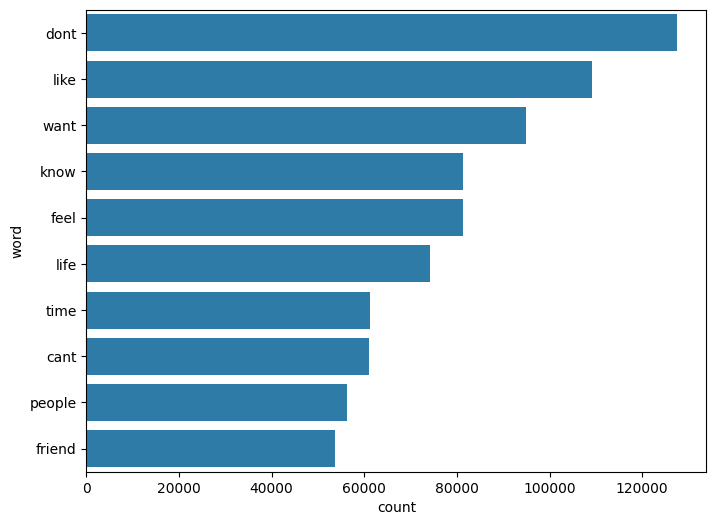

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='count',y='word',data=word_freq.iloc[:10], color='#1a80bb')
plt.show()

In [ ]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
val_output = lbl_target.transform(val_data['class'])
test_output=lbl_target.transform(test_data['class'])

## FASTTEXT

In [ ]:
!pip install gensim

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
fasttext_path = '/content/drive/MyDrive/suicide detection/cc.en.300.vec'

# Load FastText model
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_path, binary=False)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import KeyedVectors
v = len(tokenizer.word_index)
embedding_dim = 300
embedding_matrix = np.zeros((v+ 1, embedding_dim))

# Use tokenizer.word_index to access the word index
for word, idx in tokenizer.word_index.items():
    if word in fasttext_model:
        embedding_matrix[idx] = fasttext_model[word]

## GLOVE

In [ ]:
# with open('/content/drive/MyDrive/glove.840B.300d (1).pkl', 'rb') as fp:
#     glove_embedding = pickle.load(fp)

In [ ]:
# v=len(tokenizer.word_index)

# embedding_matrix=np.zeros((v+1,300), dtype=float)
# for word,idx in tokenizer.word_index.items():
#     embedding_vector=glove_embedding.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[idx]=embedding_vector

In [ ]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [ ]:
input_length = 50

## CNN

In [ ]:
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization, Input
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.regularizers import l2

# # Define the model
# model = Sequential()
# model.add(Input(shape=(50,)))
# model.add(Embedding(v+1, 300, weights=[embedding_matrix], trainable=False))

# # Using Convolutional layers
# model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
# model.add(GlobalMaxPooling1D())
# model.add(Dropout(0.5))
# model.add(BatchNormalization())  # Adding batch normalization

# model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model (example)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(
#     n_estimators=100,        # Number of trees
#     max_depth=6,             # Maximum depth of a tree
#     random_state=42          # Seed for reproducibility
# )




## GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import SGD, Adam

# Define the model
model = Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(v + 1, 300, weights=[embedding_matrix], trainable=False))
model.add(GRU(60, return_sequences=True))  # Replacing LSTM with GRU
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))  # Optional dropout layer for regularization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))  # Optional dropout layer for regularization
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

## RNN MODEL

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Embedding, SimpleRNN, GlobalMaxPooling1D, Dense
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import BatchNormalization, Dropout

# model = Sequential()
# model.add(Input(shape=(50,)))
# model.add(Embedding(v + 1, 300, weights=[embedding_matrix], trainable=False))
# model.add(SimpleRNN(50, return_sequences=True))
# model.add(GlobalMaxPooling1D())
# model.add(BatchNormalization())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Bidirectional LSTM

In [ ]:
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.regularizers import l2
# model = Sequential()
# model.add(Input(shape=(50,)))
# model.add(Embedding(v+1, 300, weights=[embedding_matrix], trainable=False))

# # Using Bidirectional LSTM
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
# model.add(GlobalMaxPooling1D())
# model.add(Dropout(0.5))
# model.add(BatchNormalization())  # Adding batch normalization

# model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='sigmoid'))
# # model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## LSTM

In [ ]:
# from tensorflow.keras.optimizers import Adam
# model=Sequential()
# model.add(Input(shape=(50,)))
# model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
# model.add(LSTM(20,return_sequences=True))
# model.add(GlobalMaxPooling1D())
# model.add(Dropout(0.3))
# model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1,activation='sigmoid'))
# #model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
r=model.fit(train_text_pad, train_output, validation_data = (test_text_pad,test_output) , epochs=10 , batch_size=256 , callbacks = [early_stop,reducelr] )

Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 172s 298ms/step - accuracy: 0.8266 - loss: 0.3692 - val_accuracy: 0.9055 - val_loss: 0.2395 - learning_rate: 0.0010
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 129s 237ms/step - accuracy: 0.9057 - loss: 0.2413 - val_accuracy: 0.9134 - val_loss: 0.2211 - learning_rate: 0.0010
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 142s 237ms/step - accuracy: 0.9137 - loss: 0.2205 - val_accuracy: 0.9176 - val_loss: 0.2123 - learning_rate: 0.0010
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 129s 237ms/step - accuracy: 0.9195 - loss: 0.2086 - val_accuracy: 0.9217 - val_loss: 0.2033 - learning_rate: 0.0010
Epoch 5/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 130s 240ms/step - accuracy: 0.9233 - loss: 0.1990 - val_accuracy: 0.9225 - val_loss: 0.2012 - learning_rate: 0.0010
Epoch 6/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 146s 246ms/step - accuracy: 0.9264 - loss: 0.1894 - val_accuracy: 0.9269 - val_loss: 0.1941 - learning_rate: 0.0010
Epoch 7/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 137s 237ms/step - accura

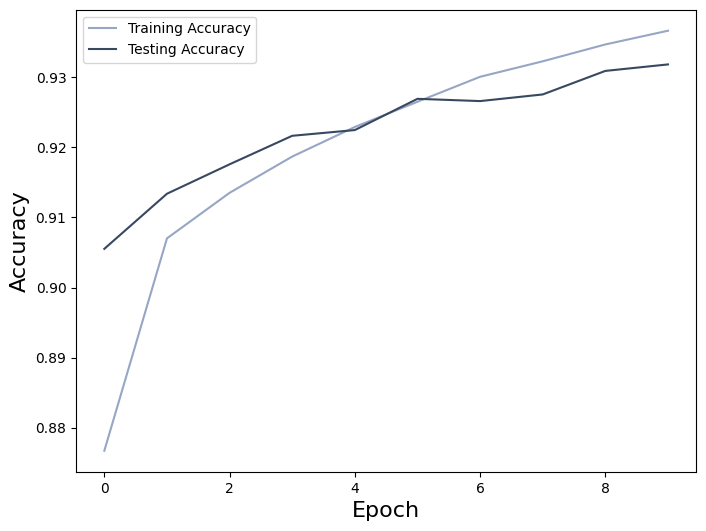

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(r.history['accuracy'], label='Training Accuracy', color='#97a6c4')
plt.plot(r.history['val_accuracy'], label='Testing Accuracy', color='#384860')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend()
plt.show()


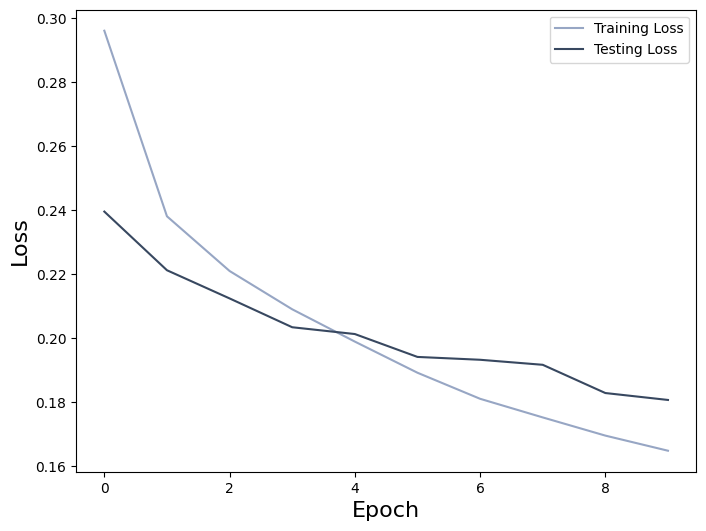

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(r.history['loss'], label='Training Loss', color='#97a6c4')
plt.plot(r.history['val_loss'], label='Testing Loss', color='#384860')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
plt.show()


In [ ]:
test_predictions = model.predict(test_text_pad)
test_pred_classes = (test_predictions > 0.5).astype(int).flatten()

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step


In [ ]:
val_predictions = model.predict(val_text_pad)
val_pred_classes = (test_predictions > 0.5).astype(int).flatten()

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step


In [ ]:
train_predictions = model.predict(train_text_pad)
train_pred_classes = (train_predictions > 0.5).astype(int).flatten()

4352/4352 ━━━━━━━━━━━━━━━━━━━━ 100s 23ms/step


In [ ]:
print('TESTING DATA CLASSIFICATION REPORT\n \n')
print(classification_report(test_output, test_pred_classes, target_names=lbl_target.inverse_transform([0, 1]), digits=4))

TESTING DATA CLASSIFICATION REPORT
 

              precision    recall  f1-score   support

 non-suicide     0.9382    0.9246    0.9314     23209
     suicide     0.9257    0.9391    0.9323     23206

    accuracy                         0.9319     46415
   macro avg     0.9319    0.9319    0.9319     46415
weighted avg     0.9319    0.9319    0.9319     46415



In [ ]:
print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output, train_pred_classes, target_names=lbl_target.inverse_transform([0, 1]), digits=4))

TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide     0.9643    0.9235    0.9434     69601
     suicide     0.9267    0.9658    0.9458     69643

    accuracy                         0.9447    139244
   macro avg     0.9455    0.9446    0.9446    139244
weighted avg     0.9454    0.9447    0.9446    139244

